In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [26]:
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/My Drive/crop_yields.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
df.head()

,Timestamp,Field_ID,Crop_Type,Disease_Class,Healthy_Area,Weed_Area,Soil_Area,NDVI,Weather,Historical_Yield,Yield_Target
0,2015-01-01,F0001,Cabbage,Healthy,0.77,0.08,0.15,0.72,Moderate,39.5,34.5
1,2016-01-01,F0001,Cabbage,Canker,0.73,0.02,0.25,0.75,Moderate,92.0,80.8
2,2017-01-01,F0001,Cabbage,Healthy,0.83,0.03,0.14,0.84,Cold,92.4,77.7
3,2018-01-01,F0001,Cabbage,Yellow_Leaf_Curl_Virus,0.59,0.13,0.28,0.69,Moderate,108.4,117.2
4,2019-01-01,F0001,Cabbage,Healthy,0.75,0.05,0.20,0.70,Warm,90.7,73.8


In [28]:
df.tail()

,Timestamp,Field_ID,Crop_Type,Disease_Class,Healthy_Area,Weed_Area,Soil_Area,NDVI,Weather,Historical_Yield,Yield_Target
9995,2020-01-01,F1000,Orange,Healthy,0.87,0.08,0.05,0.67,Warm,97.9,82.1
9996,2021-01-01,F1000,Wheat,Healthy,0.90,0.06,0.04,0.82,Moderate,123.4,134.2
9997,2022-01-01,F1000,Orange,Septoria_Leaf_Spot,0.58,0.09,0.33,0.60,Moderate,112.4,120.8
9998,2023-01-01,F1000,Orange,Healthy,0.78,0.02,0.20,0.70,Cold,82.0,97.3
9999,2024-01-01,F1000,Cucumber,Healthy,0.89,0.10,0.01,0.73,Cold,102.5,98.8


In [29]:
df.shape

(10000, 11)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Timestamp         10000 non-null  object 
 1   Field_ID          10000 non-null  object 
 2   Crop_Type         10000 non-null  object 
 3   Disease_Class     10000 non-null  object 
 4   Healthy_Area      10000 non-null  float64
 5   Weed_Area         10000 non-null  float64
 6   Soil_Area         10000 non-null  float64
 7   NDVI              10000 non-null  float64
 8   Weather           10000 non-null  object 
 9   Historical_Yield  10000 non-null  float64
 10  Yield_Target      10000 non-null  float64
dtypes: float64(6), object(5)
memory usage: 859.5+ KB


In [31]:
df.isnull().sum()

,0
Timestamp,0
Field_ID,0
Crop_Type,0
Disease_Class,0
Healthy_Area,0
Weed_Area,0
Soil_Area,0
NDVI,0
Weather,0
Historical_Yield,0


In [32]:
categorical_cols = ['Field_ID', 'Crop_Type', 'Disease_Class', 'Weather']
for col in categorical_cols:
    print(f"\n{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Value counts:")
    print(df[col].value_counts())


Field_ID:
  Unique values: 1000
  Value counts:
Field_ID
F1000    10
F0001    10
F0002    10
F0003    10
F0004    10
         ..
F0013    10
F0012    10
F0011    10
F0010    10
F0009    10
Name: count, Length: 1000, dtype: int64

Crop_Type:
  Unique values: 38
  Value counts:
Crop_Type
Pea             371
Bell_Pepper     336
Sorghum         335
Grape           334
Yam             316
Black_Bean      312
Chickpea        305
Rye             293
Orange          291
Rubber          290
Lentil          286
Cucumber        285
Taro            284
Banana          283
Barley          283
Potato          278
Sugarcane       275
Cabbage         273
Cassava         272
Tobacco         271
Cotton          267
Sweet_Potato    265
Carrot          249
Peanut          241
Tea             240
Cocoa           238
Tomato          234
Pepper          232
Coffee          232
Mango           227
Apple           222
Oats            221
Soybean         220
Wheat           217
Rice            196
Millet      

In [33]:
numerical_cols = ['Healthy_Area', 'Weed_Area', 'Soil_Area', 'NDVI', 'Historical_Yield', 'Yield_Target']

for col in numerical_cols:
    print(f"\n{col}:")
    print(f"  Min: {df[col].min():.2f}")
    print(f"  Max: {df[col].max():.2f}")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Median: {df[col].median():.2f}")
    print(f"  Std Dev: {df[col].std():.2f}")
    print(f"  Skewness: {df[col].skew():.2f}")


Healthy_Area:
  Min: 0.45
  Max: 0.95
  Mean: 0.74
  Median: 0.77
  Std Dev: 0.14
  Skewness: -0.40

Weed_Area:
  Min: 0.02
  Max: 0.15
  Mean: 0.09
  Median: 0.09
  Std Dev: 0.04
  Skewness: -0.02

Soil_Area:
  Min: -0.10
  Max: 0.53
  Mean: 0.18
  Median: 0.15
  Std Dev: 0.15
  Skewness: 0.37

NDVI:
  Min: 0.55
  Max: 0.85
  Mean: 0.71
  Median: 0.71
  Std Dev: 0.08
  Skewness: -0.06

Historical_Yield:
  Min: 24.60
  Max: 212.20
  Mean: 102.11
  Median: 101.10
  Std Dev: 34.08
  Skewness: 0.12

Yield_Target:
  Min: 25.00
  Max: 215.00
  Mean: 102.56
  Median: 101.80
  Std Dev: 35.39
  Skewness: 0.10


In [34]:
df['Yield_Diff'] = df['Yield_Target'] - df['Historical_Yield']
print(f"Yield Difference (Target - Historical):")
print(f"  Mean: {df['Yield_Diff'].mean():.2f}")
print(f"  Median: {df['Yield_Diff'].median():.2f}")
print(f"  Min: {df['Yield_Diff'].min():.2f}")
print(f"  Max: {df['Yield_Diff'].max():.2f}")
print(f"  Std Dev: {df['Yield_Diff'].std():.2f}")

Yield Difference (Target - Historical):
  Mean: 0.45
  Median: 0.40
  Min: -19.40
  Max: 19.90
  Std Dev: 10.13


In [35]:
df.duplicated().sum()

np.int64(0)

In [36]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
print(f"Date Range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
print(f"Total Years: {(df['Timestamp'].max() - df['Timestamp'].min()).days / 365:.1f}")
print(f"\nRecords per Year:")
print(df['Timestamp'].dt.year.value_counts().sort_index())

Date Range: 2015-01-01 00:00:00 to 2024-01-01 00:00:00
Total Years: 9.0

Records per Year:
Timestamp
2015    1000
2016    1000
2017    1000
2018    1000
2019    1000
2020    1000
2021    1000
2022    1000
2023    1000
2024    1000
Name: count, dtype: int64


In [37]:
print(f"Total Fields: {df['Field_ID'].nunique()}")
print(f"Records per Field:")
print(df['Field_ID'].value_counts().sort_index())

Total Fields: 1000
Records per Field:
Field_ID
F0001    10
F0002    10
F0003    10
F0004    10
F0005    10
         ..
F0996    10
F0997    10
F0998    10
F0999    10
F1000    10
Name: count, Length: 1000, dtype: int64


In [38]:
print(f"Total Crop Types: {df['Crop_Type'].nunique()}")
print(f"Crop Distribution:")
print(df['Crop_Type'].value_counts())

print(f"\nAverage Yield by Crop Type:")
print(df.groupby('Crop_Type')[['Historical_Yield', 'Yield_Target']].mean().round(2))


Total Crop Types: 38
Crop Distribution:
Crop_Type
Pea             371
Bell_Pepper     336
Sorghum         335
Grape           334
Yam             316
Black_Bean      312
Chickpea        305
Rye             293
Orange          291
Rubber          290
Lentil          286
Cucumber        285
Taro            284
Banana          283
Barley          283
Potato          278
Sugarcane       275
Cabbage         273
Cassava         272
Tobacco         271
Cotton          267
Sweet_Potato    265
Carrot          249
Peanut          241
Tea             240
Cocoa           238
Tomato          234
Pepper          232
Coffee          232
Mango           227
Apple           222
Oats            221
Soybean         220
Wheat           217
Rice            196
Millet          187
Onion           175
Corn            164
Name: count, dtype: int64

Average Yield by Crop Type:
              Historical_Yield  Yield_Target
Crop_Type                                   
Apple                   107.54        107.88


In [39]:
print(f"Total Disease Classes: {df['Disease_Class'].nunique()}")
print(f"Top 10 Disease Classes:")
print(df['Disease_Class'].value_counts().head(10))

print(f"\nAverage Yield by Disease Class (Top 5):")
disease_yield = df.groupby('Disease_Class')[['Yield_Target']].mean().sort_values('Yield_Target', ascending=False)
print(disease_yield.head())

Total Disease Classes: 20
Top 10 Disease Classes:
Disease_Class
Healthy                   5523
Bacterial_Spot             392
Late_Blight                307
Early_Blight               290
Leaf_Mold                  243
Yellow_Leaf_Curl_Virus     237
Canker                     235
Mosaic_Virus               233
Scab                       226
Target_Spot                226
Name: count, dtype: int64

Average Yield by Disease Class (Top 5):
                Yield_Target
Disease_Class               
Fusarium_Wilt     106.857674
Canker            105.080000
Powdery_Mildew    103.809326
Target_Spot       103.699558
black_spot        103.421463


In [40]:
print(f"Weather Categories:")
print(df['Weather'].value_counts())
print(f"\nPercentage:")
print((df['Weather'].value_counts() / len(df) * 100).round(2))

print(f"\nAverage Yield by Weather:")
print(df.groupby('Weather')[['Historical_Yield', 'Yield_Target']].mean().round(2))

Weather Categories:
Weather
Moderate    5941
Warm        2688
Cold        1371
Name: count, dtype: int64

Percentage:
Weather
Moderate    59.41
Warm        26.88
Cold        13.71
Name: count, dtype: float64

Average Yield by Weather:
          Historical_Yield  Yield_Target
Weather                                 
Cold                 91.50         91.67
Moderate            101.88        102.41
Warm                108.03        108.45


In [41]:
print(f"Healthy_Area Statistics:")
print(f"  Min: {df['Healthy_Area'].min():.4f}")
print(f"  Max: {df['Healthy_Area'].max():.4f}")
print(f"  Mean: {df['Healthy_Area'].mean():.4f}")

print(f"\nWeed_Area Statistics:")
print(f"  Min: {df['Weed_Area'].min():.4f}")
print(f"  Max: {df['Weed_Area'].max():.4f}")
print(f"  Mean: {df['Weed_Area'].mean():.4f}")

print(f"\nSoil_Area Statistics:")
print(f"  Min: {df['Soil_Area'].min():.4f}")
print(f"  Max: {df['Soil_Area'].max():.4f}")
print(f"  Mean: {df['Soil_Area'].mean():.4f}")

# Total composition check
df['Total_Area'] = df['Healthy_Area'] + df['Weed_Area'] + df['Soil_Area']
print(f"\nTotal Area Sum Statistics:")
print(f"  Min: {df['Total_Area'].min():.4f}")
print(f"  Max: {df['Total_Area'].max():.4f}")
print(f"  Mean: {df['Total_Area'].mean():.4f}")

Healthy_Area Statistics:
  Min: 0.4500
  Max: 0.9500
  Mean: 0.7372

Weed_Area Statistics:
  Min: 0.0200
  Max: 0.1500
  Mean: 0.0852

Soil_Area Statistics:
  Min: -0.1000
  Max: 0.5300
  Mean: 0.1775

Total Area Sum Statistics:
  Min: 0.9900
  Max: 1.0100
  Mean: 0.9999


In [42]:
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"\n{col}:")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")


Healthy_Area:
  Outliers: 0 (0.00%)

Weed_Area:
  Outliers: 0 (0.00%)

Soil_Area:
  Outliers: 0 (0.00%)

NDVI:
  Outliers: 0 (0.00%)

Historical_Yield:
  Outliers: 24 (0.24%)

Yield_Target:
  Outliers: 26 (0.26%)


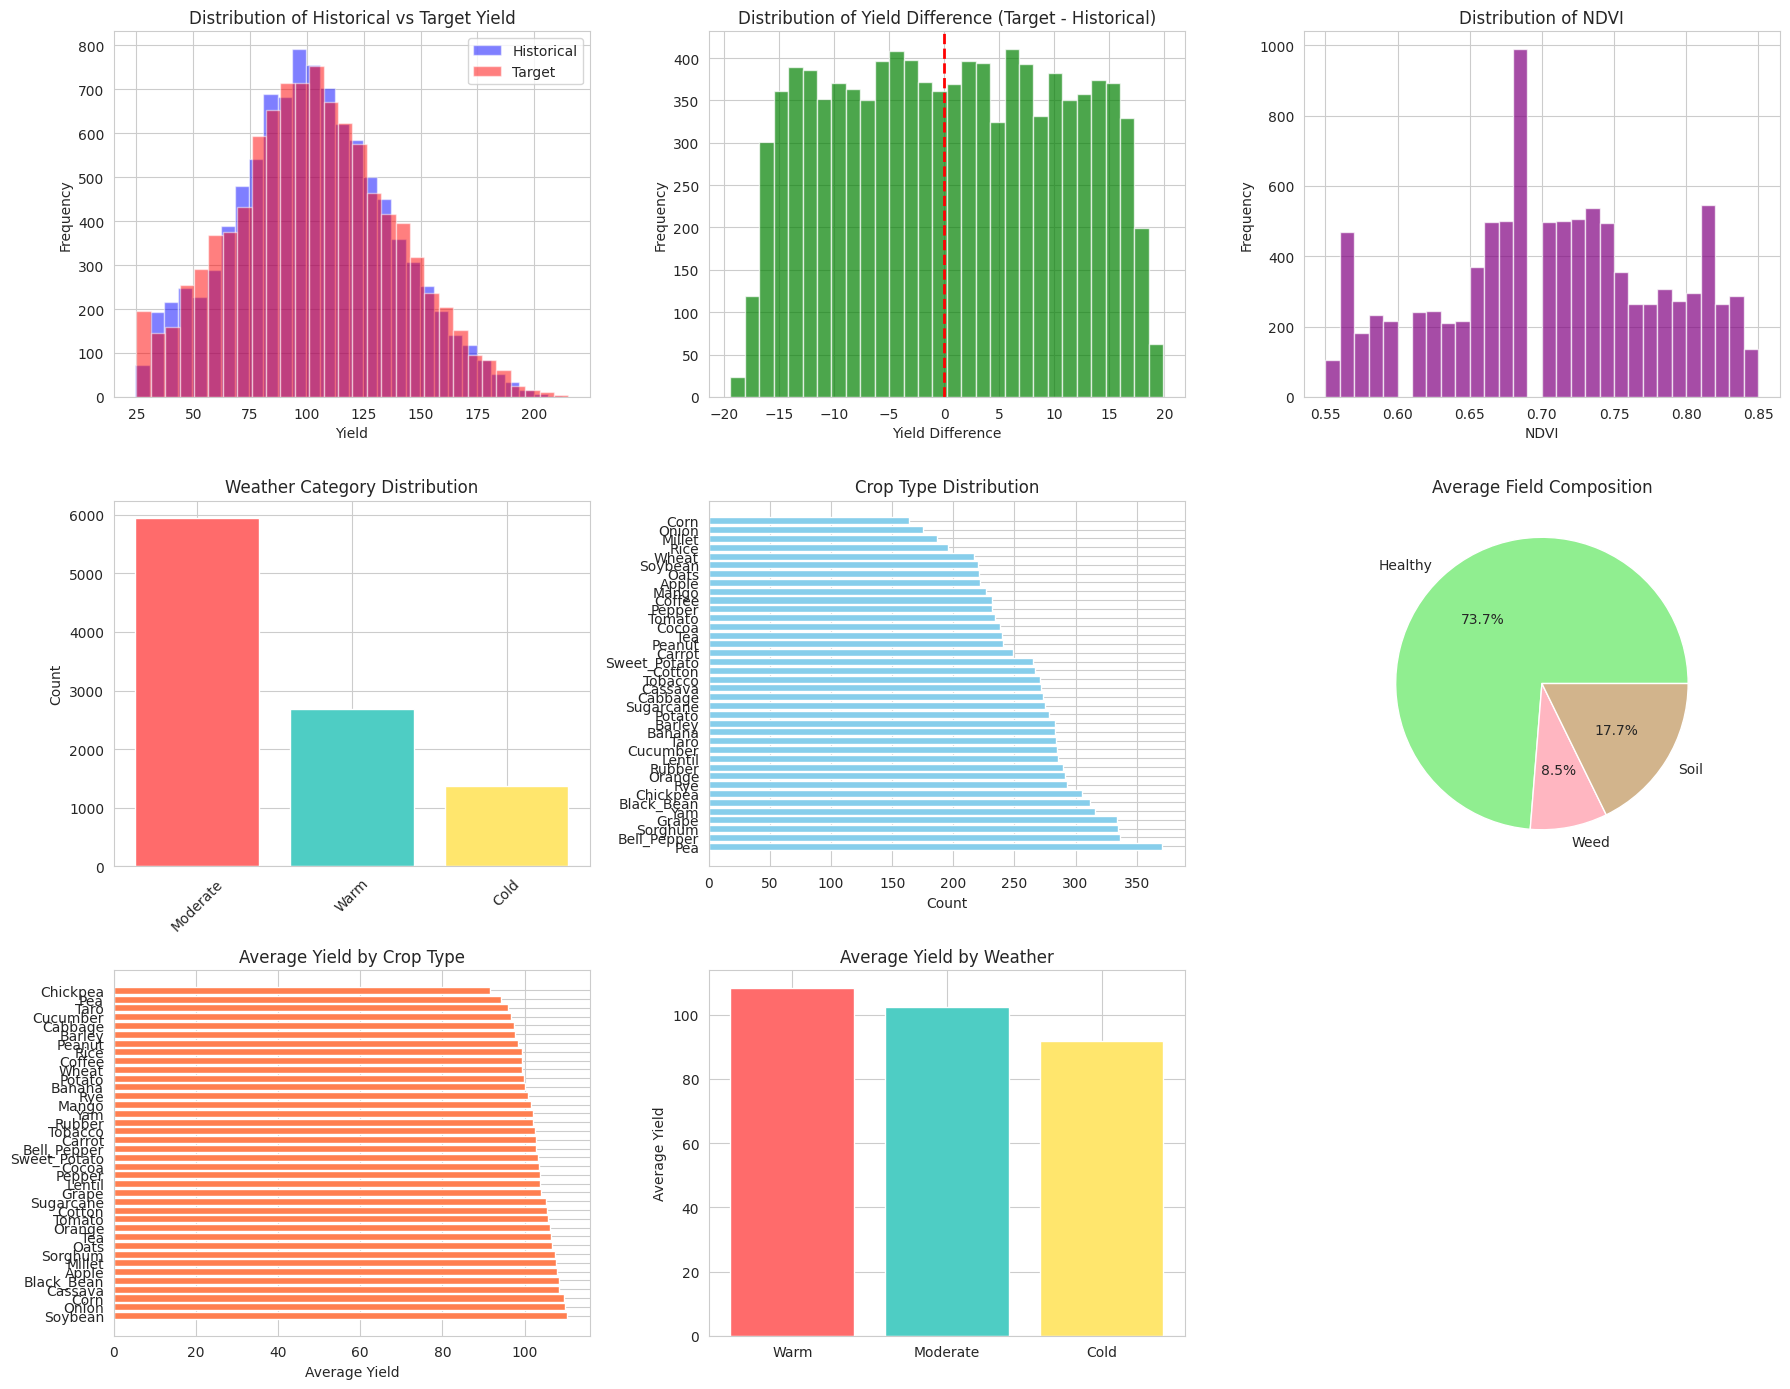

In [44]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)

# Create subplots
fig = plt.figure(figsize=(18, 14))

# Plot 1: Yield Distribution
ax1 = plt.subplot(3, 3, 1)
plt.hist(df['Historical_Yield'], bins=30, alpha=0.5, label='Historical', color='blue')
plt.hist(df['Yield_Target'], bins=30, alpha=0.5, label='Target', color='red')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.title('Distribution of Historical vs Target Yield')
plt.legend()

# Plot 2: Yield Difference
ax2 = plt.subplot(3, 3, 2)
plt.hist(df['Yield_Diff'], bins=30, color='green', alpha=0.7)
plt.xlabel('Yield Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Yield Difference (Target - Historical)')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Plot 3: NDVI Distribution
ax3 = plt.subplot(3, 3, 3)
plt.hist(df['NDVI'], bins=30, color='purple', alpha=0.7)
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.title('Distribution of NDVI')

# Plot 4: Weather Distribution
ax4 = plt.subplot(3, 3, 4)
weather_counts = df['Weather'].value_counts()
plt.bar(weather_counts.index, weather_counts.values, color=['#FF6B6B', '#4ECDC4', '#FFE66D'])
plt.ylabel('Count')
plt.title('Weather Category Distribution')
plt.xticks(rotation=45)

# Plot 5: Crop Type Distribution
ax5 = plt.subplot(3, 3, 5)
crop_counts = df['Crop_Type'].value_counts()
plt.barh(crop_counts.index, crop_counts.values, color='skyblue')
plt.xlabel('Count')
plt.title('Crop Type Distribution')

# Plot 6: Field Composition
ax6 = plt.subplot(3, 3, 6)
composition = [df['Healthy_Area'].mean(), df['Weed_Area'].mean(), df['Soil_Area'].mean()]
labels = ['Healthy', 'Weed', 'Soil']
colors = ['#90EE90', '#FFB6C1', '#D2B48C']
plt.pie(composition, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title('Average Field Composition')

# Plot 7: Yield by Crop Type
ax7 = plt.subplot(3, 3, 7)
crop_yield = df.groupby('Crop_Type')['Yield_Target'].mean().sort_values(ascending=False)
plt.barh(crop_yield.index, crop_yield.values, color='coral')
plt.xlabel('Average Yield')
plt.title('Average Yield by Crop Type')

# Plot 8: Yield by Weather
ax8 = plt.subplot(3, 3, 8)
weather_yield = df.groupby('Weather')['Yield_Target'].mean().sort_values(ascending=False)
plt.bar(weather_yield.index, weather_yield.values, color=['#FF6B6B', '#4ECDC4', '#FFE66D'])
plt.ylabel('Average Yield')
plt.title('Average Yield by Weather')


plt.tight_layout()
plt.show()

In [67]:
# Convert timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(['Field_ID', 'Timestamp']).reset_index(drop=True)

In [80]:
le_weather = LabelEncoder()
le_crop = LabelEncoder()
le_disease = LabelEncoder()

df['Weather_Encoded'] = le_weather.fit_transform(df['Weather'])
df['Crop_Type_Encoded'] = le_crop.fit_transform(df['Crop_Type'])
df['Disease_Encoded'] = le_disease.fit_transform(df['Disease_Class'])

numerical_features = ['Historical_Yield', 'NDVI', 'Healthy_Area', 'Weed_Area', 'Soil_Area']
categorical_features = ['Weather_Encoded', 'Crop_Type_Encoded', 'Disease_Encoded']
all_features = numerical_features + categorical_features

print(f"Selected features: {all_features}")

Selected features: ['Historical_Yield', 'NDVI', 'Healthy_Area', 'Weed_Area', 'Soil_Area', 'Weather_Encoded', 'Crop_Type_Encoded', 'Disease_Encoded']


In [81]:
scalers = {}
df_scaled = df.copy()

for feature in all_features:
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled[feature] = scaler.fit_transform(df[[feature]])
    scalers[feature] = scaler

scaler_target = MinMaxScaler(feature_range=(0, 1))
df_scaled['Yield_Target_Scaled'] = scaler_target.fit_transform(df[['Yield_Target']])

In [82]:
def create_seq2seq_sequences(data, field_ids, lookback=5):
    X_encoder = []
    y_decoder = []

    for field_id in field_ids:
        field_data = data[data['Field_ID'] == field_id].reset_index(drop=True)

        if len(field_data) < lookback + 1:
            continue

        for i in range(len(field_data) - lookback):
            encoder_seq = field_data[all_features].iloc[i:i+lookback].values
            X_encoder.append(encoder_seq)

            target_yield = field_data['Yield_Target_Scaled'].iloc[i+lookback]
            y_decoder.append(target_yield)

    return np.array(X_encoder), np.array(y_decoder)

field_ids = df_scaled['Field_ID'].unique()
X_encoder, y_decoder = create_seq2seq_sequences(df_scaled, field_ids, lookback=5)
print(f"  Encoder input shape: {X_encoder.shape}")
print(f"  Decoder target shape: {y_decoder.shape}")

  Encoder input shape: (5000, 5, 8)
  Decoder target shape: (5000,)


In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoder, y_decoder, test_size=0.2, random_state=42
)

print(f" Train set: {X_train.shape}")
print(f" Test set: {X_test.shape}")

 Train set: (4000, 5, 8)
 Test set: (1000, 5, 8)


BUILDING ENHANCED SEQ2SEQ MODEL

In [84]:
lookback = X_train.shape[1]
num_features = X_train.shape[2]
latent_dim = 256

encoder_inputs = Input(shape=(lookback, num_features), name='encoder_input')

encoder_lstm = Bidirectional(LSTM(latent_dim, dropout=0.3, recurrent_dropout=0.3,
                                  return_state=True, name='encoder_lstm'))

encoder_outputs, state_h1, state_c1, state_h2, state_c2 = encoder_lstm(encoder_inputs)

state_h = tf.keras.layers.Concatenate()([state_h1, state_h2])
state_c = tf.keras.layers.Concatenate()([state_c1, state_c2])

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(1,), name='decoder_input')

decoder_expanded = tf.keras.layers.Reshape((1, 1))(decoder_inputs)
decoder_expanded = Dense(num_features, activation='relu')(decoder_expanded)

decoder_lstm = LSTM(latent_dim * 2, dropout=0.3, recurrent_dropout=0.3,
                    return_sequences=True, name='decoder_lstm')(
                    decoder_expanded, initial_state=encoder_states)

decoder_bn = BatchNormalization()(decoder_lstm)

decoder_td = tf.keras.layers.TimeDistributed(Dense(128, activation='relu'))(decoder_bn)
decoder_td_dropout = Dropout(0.2)(decoder_td)

decoder_flat = tf.keras.layers.Flatten()(decoder_td_dropout)
decoder_dense1 = Dense(256, activation='relu', name='decoder_dense1')(decoder_flat)
decoder_dropout1 = Dropout(0.2)(decoder_dense1)

decoder_dense2 = Dense(128, activation='relu', name='decoder_dense2')(decoder_dropout1)
decoder_dropout2 = Dropout(0.2)(decoder_dense2)

decoder_dense3 = Dense(64, activation='relu', name='decoder_dense3')(decoder_dropout2)
decoder_dropout3 = Dropout(0.2)(decoder_dense3)

decoder_outputs = Dense(1, activation='sigmoid', name='yield_output')(decoder_dropout3)

model = Model(inputs=[encoder_inputs, decoder_inputs],
              outputs=decoder_outputs,
              name='Seq2Seq_LSTM_7percent')

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='mse',
              metrics=['mae'])

print(" Model built successfully")
print(model.summary())

 Model built successfully


Model: "Seq2Seq_LSTM_7percent"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_input       │ (None, 5, 8)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1, 1)      │          0 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ [(None, 512),     │    542,720 │ encoder_input[0]… │
│ (Bidirectional)     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1, 8)      │         16 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 512)       │          0 │ bidirectional_6[… │
│ (Concatenate)       │                   │            │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 512)       │          0 │ bidirectional_6[… │
│ (Concatenate)       │                   │            │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ (None, 1, 512)    │  1,067,008 │ dense_11[0][0],   │
│                     │                   │            │ concatenate_11[0… │
│                     │                   │            │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 512)    │      2,048 │ decoder_lstm[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 1, 128)    │     65,664 │ batch_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 1, 128)    │          0 │ time_distributed… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 128)       │          0 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense1      │ (None, 256)       │     33,024 │ flatten_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 256)       │          0 │ decoder_dense1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense2      │ (None, 128)       │     32,896 │ dropout_19[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128)       │          0 │ decoder_dense2[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,751,697 (6.68 MB)

 Trainable params: 1,750,673 (6.68 MB)

 Non-trainable params: 1,024 (4.00 KB)

None


TRAIN

In [85]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20,
                               restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=8, min_lr=1e-7, verbose=1)

history = model.fit(
    [X_train, y_train],
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(" Training completed")

Epoch 1/150
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - loss: 0.0264 - mae: 0.1304 - val_loss: 0.0259 - val_mae: 0.1335 - learning_rate: 5.0000e-04
Epoch 2/150
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 0.0122 - mae: 0.0867 - val_loss: 0.0183 - val_mae: 0.1119 - learning_rate: 5.0000e-04
Epoch 3/150
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - loss: 0.0086 - mae: 0.0729 - val_loss: 0.0096 - val_mae: 0.0823 - learning_rate: 5.0000e-04
Epoch 4/150
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.0067 - mae: 0.0635 - val_loss: 0.0022 - val_mae: 0.0326 - learning_rate: 5.0000e-04
Epoch 5/150
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 0.0061 - mae: 0.0614 - val_loss: 0.0020 - val_mae: 0.0376 - learning_rate: 5.0000e-04
Epoch 6/150
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - loss: 0.0057 - mae: 0.0586 - val_loss: 0.0045 - val_mae: 0.0537 - learning_rate: 5.0000e-04
Epoch 7/150
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - loss: 0.0055 - mae: 0.0586 - val_loss: 0.003

In [86]:
y_pred_scaled = model.predict([X_test, y_test], verbose=0)
y_train_pred_scaled = model.predict([X_train, y_train], verbose=0)

y_pred = scaler_target.inverse_transform(y_pred_scaled)
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_train_pred = scaler_target.inverse_transform(y_train_pred_scaled)
y_train_actual = scaler_target.inverse_transform(y_train.reshape(-1, 1))

print("Predictions completed")

Predictions completed


In [87]:
train_mse = mean_squared_error(y_train_actual, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
train_r2 = r2_score(y_train_actual, y_train_pred)

print("\nTRAINING METRICS:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  R² Score: {train_r2:.4f}")

test_mse = mean_squared_error(y_test_actual, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_actual, y_pred)
test_r2 = r2_score(y_test_actual, y_pred)

print("\nTEST METRICS:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R² Score: {test_r2:.4f}")


TRAINING METRICS:
  RMSE: 7.0867
  MAE: 5.1499
  R² Score: 0.9470

TEST METRICS:
  RMSE: 7.2562
  MAE: 5.2969
  R² Score: 0.9464


In [88]:
def calculate_uncertainty_accuracy(y_actual, y_pred, uncertainty_percent=7):
    """Calculate predictions within ±uncertainty_percent"""
    uncertainty = np.abs(y_actual) * (uncertainty_percent / 100)
    lower_bound = y_actual - uncertainty
    upper_bound = y_actual + uncertainty

    within_range = np.sum((y_pred >= lower_bound) & (y_pred <= upper_bound))
    accuracy = (within_range / len(y_actual)) * 100

    return accuracy

train_unc_accuracy_7 = calculate_uncertainty_accuracy(y_train_actual, y_train_pred, 7)
test_unc_accuracy_7 = calculate_uncertainty_accuracy(y_test_actual, y_pred, 7)

print(f"\nTRAINING SET (±7%):")
print(f"  Accuracy: {train_unc_accuracy_7:.2f}%")
print(f"  Status: {'✓ PASSED (>75%)' if train_unc_accuracy_7 > 75 else '⚠ Target: >75%'}")

print(f"\nTEST SET (±7%):")
print(f"  Accuracy: {test_unc_accuracy_7:.2f}%")
print(f"  Status: {' PASSED (>75%)' if test_unc_accuracy_7 > 75 else '⚠ Target: >75%'}")

train_diff = y_train_actual.flatten() - y_train_pred.flatten()
test_diff = y_test_actual.flatten() - y_pred.flatten()

print(f"\nPREDICTION DIFFERENCES:")
print(f"  Train Mean Error: {np.mean(train_diff):.4f}")
print(f"  Train Std Dev: {np.std(train_diff):.4f}")
print(f"  Test Mean Error: {np.mean(test_diff):.4f}")
print(f"  Test Std Dev: {np.std(test_diff):.4f}")


TRAINING SET (±7%):
  Accuracy: 84.42%
  Status: ✓ PASSED (>75%)

TEST SET (±7%):
  Accuracy: 82.40%
  Status:  PASSED (>75%)

PREDICTION DIFFERENCES:
  Train Mean Error: -1.5484
  Train Std Dev: 6.9154
  Test Mean Error: -1.6482
  Test Std Dev: 7.0666


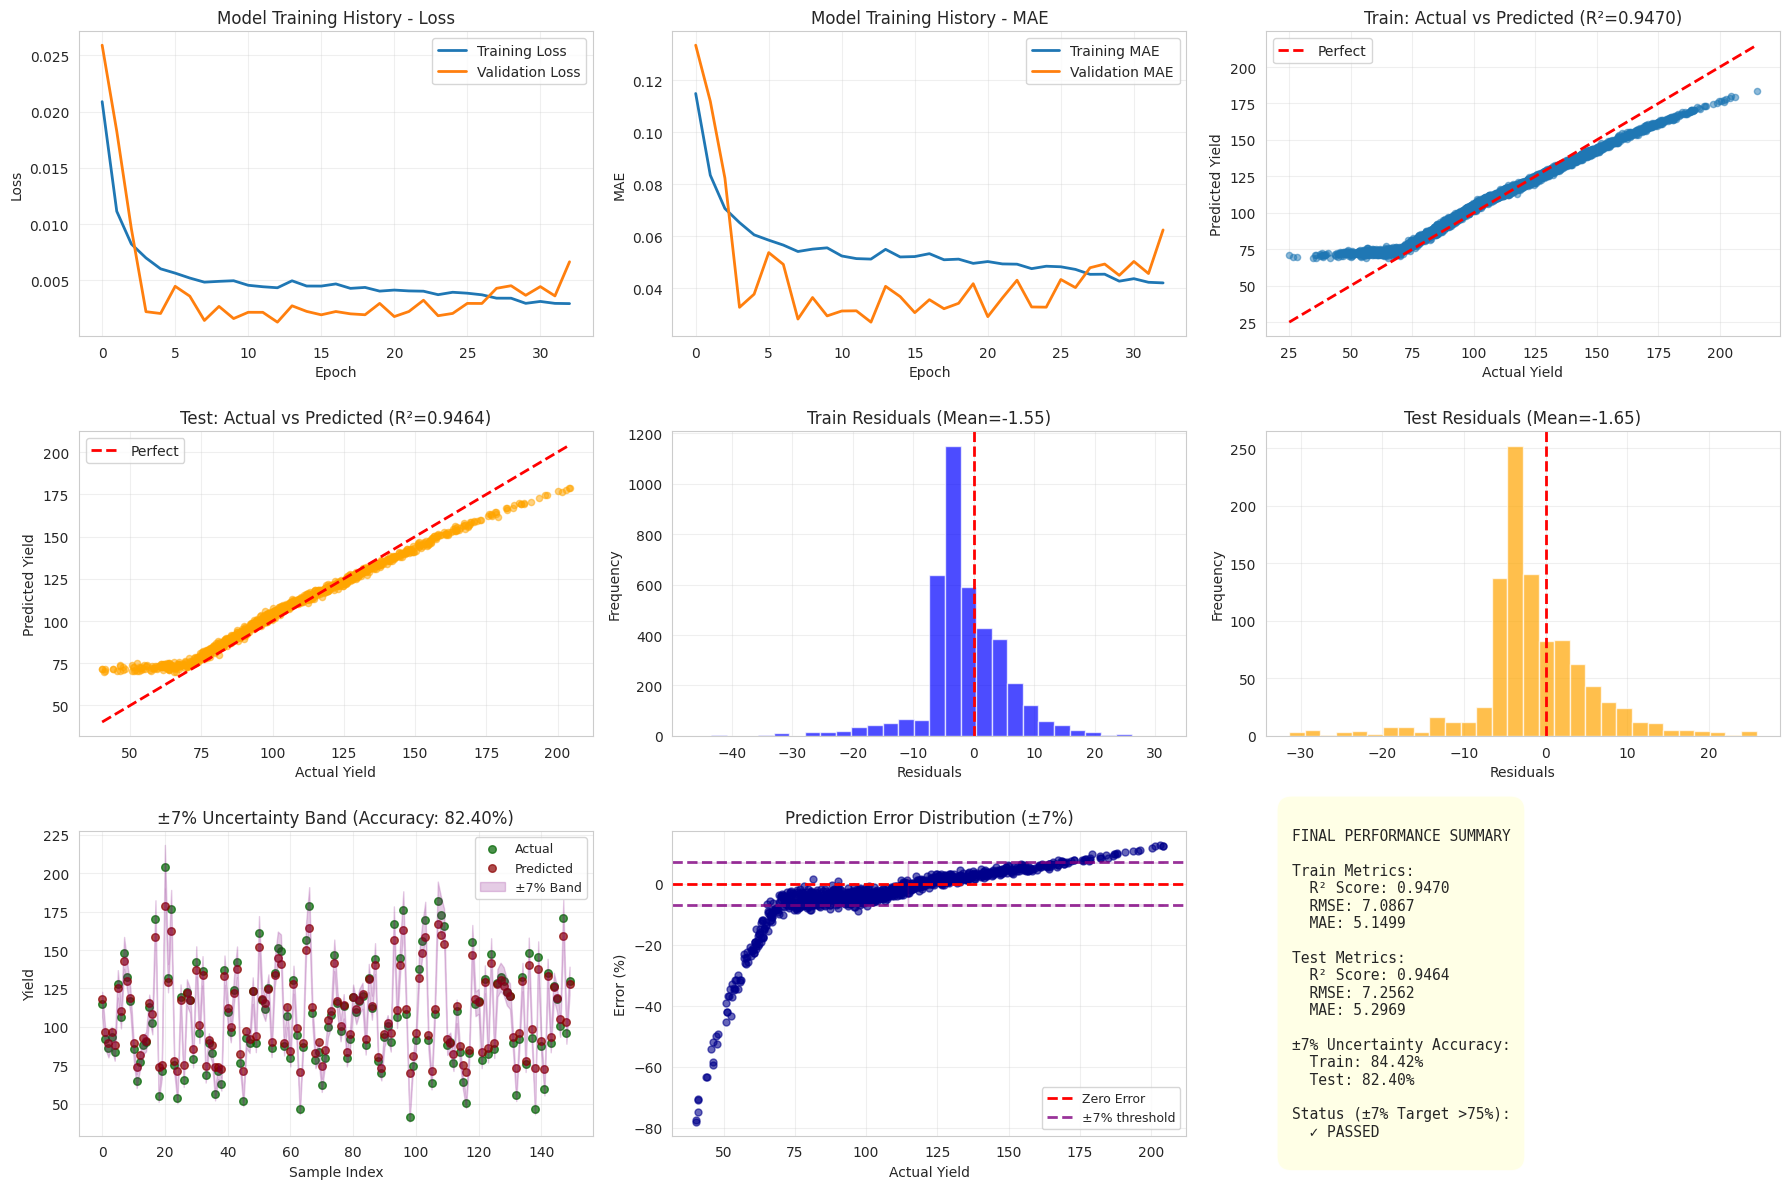

In [89]:
fig = plt.figure(figsize=(18, 12))

# Plot 1: Training History - Loss
ax1 = plt.subplot(3, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training History - Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Training History - MAE
ax2 = plt.subplot(3, 3, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Model Training History - MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Predictions vs Actual (Train)
ax3 = plt.subplot(3, 3, 3)
plt.scatter(y_train_actual, y_train_pred, alpha=0.5, s=20)
plt.plot([y_train_actual.min(), y_train_actual.max()],
         [y_train_actual.min(), y_train_actual.max()],
         'r--', lw=2, label='Perfect')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Train: Actual vs Predicted (R²={train_r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Predictions vs Actual (Test)
ax4 = plt.subplot(3, 3, 4)
plt.scatter(y_test_actual, y_pred, alpha=0.5, s=20, color='orange')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=2, label='Perfect')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Test: Actual vs Predicted (R²={test_r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Residuals Distribution (Train)
ax5 = plt.subplot(3, 3, 5)
plt.hist(train_diff, bins=30, alpha=0.7, color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title(f'Train Residuals (Mean={np.mean(train_diff):.2f})')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# Plot 6: Residuals Distribution (Test)
ax6 = plt.subplot(3, 3, 6)
plt.hist(test_diff, bins=30, alpha=0.7, color='orange')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title(f'Test Residuals (Mean={np.mean(test_diff):.2f})')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# Plot 7: ±7% Uncertainty Band (Test) - First 150 samples
ax7 = plt.subplot(3, 3, 7)
uncertainty_7 = y_test_actual * 0.07
indices = np.arange(min(150, len(y_test_actual)))
plt.scatter(indices, y_test_actual[:150], label='Actual', s=30, alpha=0.7, color='darkgreen')
plt.scatter(indices, y_pred[:150], label='Predicted', s=30, alpha=0.7, color='darkred')
plt.fill_between(indices,
                 (y_test_actual[:150] - uncertainty_7[:150]).flatten(),
                 (y_test_actual[:150] + uncertainty_7[:150]).flatten(),
                 alpha=0.2, color='purple', label='±7% Band')
plt.xlabel('Sample Index')
plt.ylabel('Yield')
plt.title(f'±7% Uncertainty Band (Accuracy: {test_unc_accuracy_7:.2f}%)')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Plot 8: Error Percentage Distribution
ax8 = plt.subplot(3, 3, 8)
error_percent = ((y_test_actual.flatten() - y_pred.flatten()) / y_test_actual.flatten()) * 100
plt.scatter(y_test_actual, error_percent, alpha=0.6, s=25, color='darkblue')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
plt.axhline(y=7, color='purple', linestyle='--', linewidth=2, alpha=0.8, label='±7% threshold')
plt.axhline(y=-7, color='purple', linestyle='--', linewidth=2, alpha=0.8)
plt.fill_between(y_test_actual.flatten(), -7, 7, alpha=0.15, color='purple')
plt.xlabel('Actual Yield')
plt.ylabel('Error (%)')
plt.title('Prediction Error Distribution (±7%)')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Plot 9: Metrics Summary
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')
summary_text = f"""
FINAL PERFORMANCE SUMMARY

Train Metrics:
  R² Score: {train_r2:.4f}
  RMSE: {train_rmse:.4f}
  MAE: {train_mae:.4f}

Test Metrics:
  R² Score: {test_r2:.4f}
  RMSE: {test_rmse:.4f}
  MAE: {test_mae:.4f}

±7% Uncertainty Accuracy:
  Train: {train_unc_accuracy_7:.2f}%
  Test: {test_unc_accuracy_7:.2f}%

Status (±7% Target >75%):
  {'✓ PASSED' if test_unc_accuracy_7 > 75 else '⚠ NEEDS WORK'}
"""
plt.text(0.05, 0.5, summary_text, fontsize=10.5, verticalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8, pad=1))

plt.tight_layout()
plt.show()

In [91]:
model.save('/content/drive/My Drive/seq2seq_lstm_model_7percent_final.h5')

import pickle
scalers_data = {
    'scalers': scalers,
    'scaler_target': scaler_target,
    'all_features': all_features,
    'le_weather': le_weather,
    'le_crop': le_crop,
    'le_disease': le_disease
}

with open('/content/drive/My Drive/seq2seq_preprocessing_7percent_final.pkl', 'wb') as f:
    pickle.dump(scalers_data, f)

print(" Model and preprocessing saved")


 Model and preprocessing saved
